## Intensity vs radius plot for condensates

Please select the TrackMate CSV file
Please select the ilastik CSV file

TrackMate columns found: ['spotID', 'trackID', 'QUALITY', 'x', 'y', 't', 'R', 'meanIntensity', 'medianIntensity', 'minIntensity', 'maxIntensity', 'totalIntensity', 'stdIntensity', 'contrast', 'SNR']
Found 141 unique tracks at t=0

ilastik columns found: ['frame', 'condensateID', 'contour_coord', 'center_x_pxl', 'center_y_pxl', 'area_um2', 'R_nm', 'mean_intensity', 'max_intensity', 'max_location', 'aspect_ratio', 'contour_solidity', 'contour_extent']
Found 127 objects at frame=0

Matching coordinates with tolerance = 0.2 pixels...

Successfully matched 103 tracks

Styled plot saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/GEM tracking/GEM_HOPS Cotracking/reformatted/hops\intensity_vs_radius_tol0.2_styled.png
Matched data saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/GEM tracking/GEM_HOPS Cotracking/reformatted/hops\matched_data_t

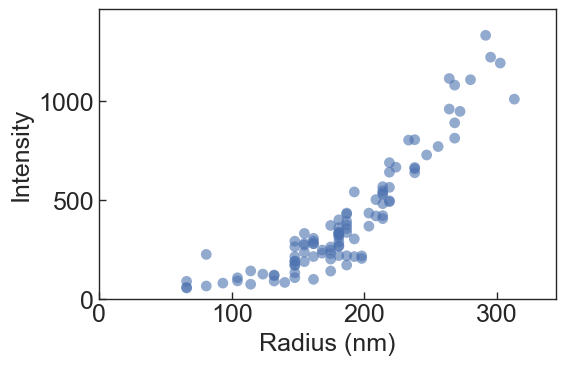

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tkinter import filedialog, Tk
import os

# Set seaborn style to match your preferences
sns.set(style="white", rc={"axes.linewidth": 1})
plt.rcParams['font.size'] = 18

def select_file(title):
    root = Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(title=title)
    root.destroy()
    return file_path

def match_and_plot():
    # Step 1: Select TrackMate CSV file
    print("Please select the TrackMate CSV file")
    trackmate_file = select_file("Select TrackMate CSV File")
    if not trackmate_file:
        print("No TrackMate file selected. Exiting.")
        return
    
    # Step 2: Select ilastik CSV file
    print("Please select the ilastik CSV file")
    ilastik_file = select_file("Select ilastik CSV File")
    if not ilastik_file:
        print("No ilastik file selected. Exiting.")
        return
    
    # Step 3: Read and process TrackMate data
    try:
        trackmate_data = pd.read_csv(trackmate_file)
        print("\nTrackMate columns found:", trackmate_data.columns.tolist())
        
        # Verify required columns exist
        trackmate_req = ['trackID', 'x', 'y', 't', 'meanIntensity']
        missing_track = [col for col in trackmate_req if col not in trackmate_data.columns]
        if missing_track:
            raise ValueError(f"Missing columns in TrackMate data: {missing_track}")
        
        # Filter for t=0 and get unique track IDs
        t0_trackmate = trackmate_data[trackmate_data['t'] == 0].copy()
        t0_trackmate.drop_duplicates(subset=['trackID'], inplace=True)
        print(f"Found {len(t0_trackmate)} unique tracks at t=0")
        
    except Exception as e:
        print(f"\nError reading TrackMate file: {str(e)}")
        return
    
    # Step 4: Read and process ilastik data
    try:
        ilastik_data = pd.read_csv(ilastik_file)
        print("\nilastik columns found:", ilastik_data.columns.tolist())
        
        # Verify required columns exist
        ilastik_req = ['center_x_pxl', 'center_y_pxl', 'frame', 'R_nm']
        missing_ilastik = [col for col in ilastik_req if col not in ilastik_data.columns]
        if missing_ilastik:
            raise ValueError(f"Missing columns in ilastik data: {missing_ilastik}")
        
        # Filter for frame=0
        frame0_ilastik = ilastik_data[ilastik_data['frame'] == 0].copy()
        print(f"Found {len(frame0_ilastik)} objects at frame=0")
        
    except Exception as e:
        print(f"\nError reading ilastik file: {str(e)}")
        return
    
    # Step 5: Match coordinates and collect data
    matched_data = []
    tolerance = 0.2  # Tight tolerance of 0.2 pixels
    print(f"\nMatching coordinates with tolerance = {tolerance} pixels...")
    
    for _, track_row in t0_trackmate.iterrows():
        try:
            x_track = float(track_row['x'])
            y_track = float(track_row['y'])
            track_id = track_row['trackID']
            
            # Calculate distances
            x_diff = abs(frame0_ilastik['center_x_pxl'] - x_track)
            y_diff = abs(frame0_ilastik['center_y_pxl'] - y_track)
            
            # Create mask
            mask = (x_diff <= tolerance) & (y_diff <= tolerance)
            matches = frame0_ilastik[mask]
            
            if len(matches) > 0:
                ilastik_row = matches.iloc[0]
                matched_data.append({
                    'track_id': track_id,
                    'x': x_track,
                    'y': y_track,
                    'radius_nm': float(ilastik_row['R_nm']),
                    'intensity': float(track_row['meanIntensity'])
                })
                
        except Exception as e:
            print(f"Error processing track {track_id}: {str(e)}")
            continue
    
    if not matched_data:
        print("\nNo matching coordinates found between the files with tolerance=0.2.")
        print("Possible solutions:")
        print("1. Increase tolerance value")
        print("2. Check if coordinate systems are aligned")
        print("3. Verify both files contain data at t=0/frame=0")
        return
    
    # Convert to DataFrame
    results = pd.DataFrame(matched_data)
    print(f"\nSuccessfully matched {len(results)} tracks")
    
    # Step 6: Plot intensity vs radius with new aesthetics
    plt.figure(figsize=(6, 4))
    
    # Create scatter plot with custom style
    ax = sns.scatterplot(
        data=results,
        x='radius_nm',
        y='intensity',
        color="#4C72B0",  # Using your preferred blue color
        alpha=0.6,
        edgecolor='none',
        s=60  # Marker size
    )
    
    # Set axis labels and title
    plt.xlabel('Radius (nm)', fontsize=18)
    plt.ylabel('Intensity', fontsize=18)
    # plt.title(f'Intensity vs Radius at t=0\n({len(results)} matches)', fontsize=16)
    
    # Apply custom axis and tick formatting
    ax.spines[:].set_linewidth(1)
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=18,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=1,
    )
    ax.set_axisbelow(False)
    
    # Set axis limits with padding
    plt.xlim(0, results['radius_nm'].max()*1.1)
    plt.ylim(0, results['intensity'].max()*1.1)
    
    # Save the plot
    output_dir = os.path.dirname(trackmate_file)
    plot_path = os.path.join(output_dir, 'intensity_vs_radius_tol0.2_styled.png')
    plt.tight_layout()
    plt.savefig(plot_path, format="png", bbox_inches="tight", dpi=600)
    print(f"\nStyled plot saved to: {plot_path}")
    
    # Save the matched data
    results_path = os.path.join(output_dir, 'matched_data_tol0.2.csv')
    results.to_csv(results_path, index=False)
    print(f"Matched data saved to: {results_path}")
    
    # Show the plot
    plt.show()

if __name__ == "__main__":
    match_and_plot()

## Intensity vs Radius linear fitting

Please select the TrackMate CSV file
Please select the ilastik CSV file

TrackMate columns found: ['spotID', 'trackID', 'QUALITY', 'x', 'y', 't', 'R', 'meanIntensity', 'medianIntensity', 'minIntensity', 'maxIntensity', 'totalIntensity', 'stdIntensity', 'contrast', 'SNR']
Found 141 unique tracks at t=0

ilastik columns found: ['frame', 'condensateID', 'contour_coord', 'center_x_pxl', 'center_y_pxl', 'area_um2', 'R_nm', 'mean_intensity', 'max_intensity', 'max_location', 'aspect_ratio', 'contour_solidity', 'contour_extent']
Found 127 objects at frame=0

Matching coordinates with tolerance = 0.2 pixels...

Successfully matched 103 tracks

Linear fit for radius ≥ 200 nm:
Slope: 7.8637
Intercept: -1163.9783
R-squared: 0.8605

Styled plot saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/GEM tracking/GEM_HOPS Cotracking/reformatted/hops\intensity_vs_radius_tol0.2_styled.png
Matched data saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskelet

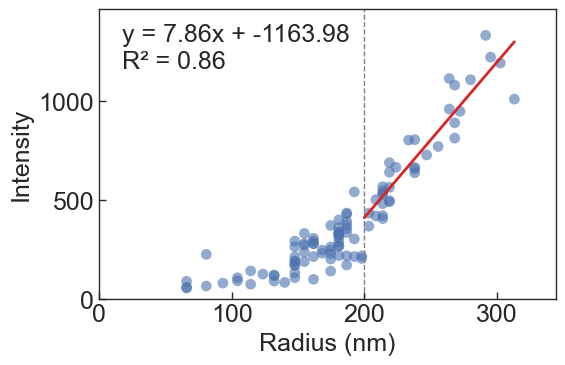

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tkinter import filedialog, Tk
import os
import numpy as np
from scipy.stats import linregress

# Set seaborn style to match your preferences
sns.set(style="white", rc={"axes.linewidth": 1})
plt.rcParams['font.size'] = 18

def select_file(title):
    root = Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(title=title)
    root.destroy()
    return file_path

def match_and_plot():
    # Step 1: Select TrackMate CSV file
    print("Please select the TrackMate CSV file")
    trackmate_file = select_file("Select TrackMate CSV File")
    if not trackmate_file:
        print("No TrackMate file selected. Exiting.")
        return
    
    # Step 2: Select ilastik CSV file
    print("Please select the ilastik CSV file")
    ilastik_file = select_file("Select ilastik CSV File")
    if not ilastik_file:
        print("No ilastik file selected. Exiting.")
        return
    
    # Step 3: Read and process TrackMate data
    try:
        trackmate_data = pd.read_csv(trackmate_file)
        print("\nTrackMate columns found:", trackmate_data.columns.tolist())
        
        # Verify required columns exist
        trackmate_req = ['trackID', 'x', 'y', 't', 'meanIntensity']
        missing_track = [col for col in trackmate_req if col not in trackmate_data.columns]
        if missing_track:
            raise ValueError(f"Missing columns in TrackMate data: {missing_track}")
        
        # Filter for t=0 and get unique track IDs
        t0_trackmate = trackmate_data[trackmate_data['t'] == 0].copy()
        t0_trackmate.drop_duplicates(subset=['trackID'], inplace=True)
        print(f"Found {len(t0_trackmate)} unique tracks at t=0")
        
    except Exception as e:
        print(f"\nError reading TrackMate file: {str(e)}")
        return
    
    # Step 4: Read and process ilastik data
    try:
        ilastik_data = pd.read_csv(ilastik_file)
        print("\nilastik columns found:", ilastik_data.columns.tolist())
        
        # Verify required columns exist
        ilastik_req = ['center_x_pxl', 'center_y_pxl', 'frame', 'R_nm']
        missing_ilastik = [col for col in ilastik_req if col not in ilastik_data.columns]
        if missing_ilastik:
            raise ValueError(f"Missing columns in ilastik data: {missing_ilastik}")
        
        # Filter for frame=0
        frame0_ilastik = ilastik_data[ilastik_data['frame'] == 0].copy()
        print(f"Found {len(frame0_ilastik)} objects at frame=0")
        
    except Exception as e:
        print(f"\nError reading ilastik file: {str(e)}")
        return
    
    # Step 5: Match coordinates and collect data
    matched_data = []
    tolerance = 0.2  # Tight tolerance of 0.2 pixels
    print(f"\nMatching coordinates with tolerance = {tolerance} pixels...")
    
    for _, track_row in t0_trackmate.iterrows():
        try:
            x_track = float(track_row['x'])
            y_track = float(track_row['y'])
            track_id = track_row['trackID']
            
            # Calculate distances
            x_diff = abs(frame0_ilastik['center_x_pxl'] - x_track)
            y_diff = abs(frame0_ilastik['center_y_pxl'] - y_track)
            
            # Create mask
            mask = (x_diff <= tolerance) & (y_diff <= tolerance)
            matches = frame0_ilastik[mask]
            
            if len(matches) > 0:
                ilastik_row = matches.iloc[0]
                matched_data.append({
                    'track_id': track_id,
                    'x': x_track,
                    'y': y_track,
                    'radius_nm': float(ilastik_row['R_nm']),
                    'intensity': float(track_row['meanIntensity'])
                })
                
        except Exception as e:
            print(f"Error processing track {track_id}: {str(e)}")
            continue
    
    if not matched_data:
        print("\nNo matching coordinates found between the files with tolerance=0.2.")
        print("Possible solutions:")
        print("1. Increase tolerance value")
        print("2. Check if coordinate systems are aligned")
        print("3. Verify both files contain data at t=0/frame=0")
        return
    
    # Convert to DataFrame
    results = pd.DataFrame(matched_data)
    print(f"\nSuccessfully matched {len(results)} tracks")
    
    # Step 6: Plot intensity vs radius with new aesthetics
    plt.figure(figsize=(6, 4))
    
    # Create scatter plot with custom style
    ax = sns.scatterplot(
        data=results,
        x='radius_nm',
        y='intensity',
        color="#4C72B0",  # Using your preferred blue color
        alpha=0.6,
        edgecolor='none',
        s=60  # Marker size
    )
    
    # Add vertical line at x = 200 nm
    plt.axvline(x=200, color='gray', linestyle='--', linewidth=1)
    
    # Fit and plot linear regression for radius ≥ 200 nm
    large_radii = results[results['radius_nm'] >= 200]
    if len(large_radii) >= 2:  # Need at least 2 points for linear fit
        x_fit = large_radii['radius_nm']
        y_fit = large_radii['intensity']
        
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x_fit, y_fit)
        
        # Create line points
        x_line = np.linspace(200, results['radius_nm'].max(), 100)
        y_line = slope * x_line + intercept
        
        # Plot the fitted line
        plt.plot(x_line, y_line, color='#D62728', linestyle='-', linewidth=2)
        
        # Add equation text in top LEFT with no frame
        equation_text = f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}'
        plt.text(0.05, 0.95, equation_text, 
                transform=ax.transAxes, 
                ha='left', 
                va='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        
        print(f"\nLinear fit for radius ≥ 200 nm:")
        print(f"Slope: {slope:.4f}")
        print(f"Intercept: {intercept:.4f}")
        print(f"R-squared: {r_value**2:.4f}")
    
    # Set axis labels and title
    plt.xlabel('Radius (nm)', fontsize=18)
    plt.ylabel('Intensity', fontsize=18)
    
    # Apply custom axis and tick formatting
    ax.spines[:].set_linewidth(1)
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=18,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=1,
    )
    ax.set_axisbelow(False)
    
    # Set axis limits with padding
    plt.xlim(0, results['radius_nm'].max()*1.1)
    plt.ylim(0, results['intensity'].max()*1.1)
    
    # Save the plot
    output_dir = os.path.dirname(trackmate_file)
    plot_path = os.path.join(output_dir, 'intensity_vs_radius_tol0.2_styled.png')
    plt.tight_layout()
    plt.savefig(plot_path, format="png", bbox_inches="tight", dpi=600)
    print(f"\nStyled plot saved to: {plot_path}")
    
    # Save the matched data
    results_path = os.path.join(output_dir, 'matched_data_tol0.2.csv')
    results.to_csv(results_path, index=False)
    print(f"Matched data saved to: {results_path}")
    
    # Show the plot
    plt.show()

if __name__ == "__main__":
    match_and_plot()

## Theoretical intensity vs experimental intensity table

In [ ]:
import pandas as pd
import numpy as np
import os
from tkinter import filedialog, Tk

def select_file(title):
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(title=title)
    root.destroy()
    return file_path

def get_random_condensate(df, intensity_range, radius_range, max_attempts=100):
    """Select a random condensate matching given intensity and radius criteria"""
    for _ in range(max_attempts):
        sample = df.sample(1)
        if (intensity_range[0] <= sample['intensity'].values[0] <= intensity_range[1] and
            radius_range[0] <= sample['radius_nm'].values[0] <= radius_range[1]):
            return sample
    return None

def calculate_theoretical_D(radius_nm, viscosity_mPas=77, temperature_K=335):
    """Calculate theoretical D using Stokes-Einstein equation with ACTUAL radius"""
    kB = 1.380649e-23  # Boltzmann constant (J/K)
    radius_m = radius_nm * 1e-9
    viscosity_Pas = viscosity_mPas * 1e-3
    D = (kB * temperature_K) / (6 * np.pi * viscosity_Pas * radius_m)  # in m²/s
    return D * 1e12  # convert to µm²/s

# Load the matched data file
matched_data_path = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\GEM tracking\GEM_HOPS Cotracking\reformatted\hops\matched_data_tol0.2.csv"
matched_df = pd.read_csv(matched_data_path)

# Load the SPT results file
spt_results_path = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\GEM tracking\GEM_HOPS Cotracking\reformatted\hops\SPT_results_AIO-40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-1-bandpass-even_reformatted.csv"
spt_df = pd.read_csv(spt_results_path)

# Define selection criteria
selection_criteria = [
    {'intensity': (0, 200), 'radius': (0, 100)},
    {'intensity': (400, 600), 'radius': (100, 250)},
    {'intensity': (800, 1000), 'radius': (250, 300)},
    {'intensity': (1000, np.inf), 'radius': (300, np.inf)}
]

# Create results table
results = []

for criteria in selection_criteria:
    found = False
    attempts = 0
    
    while not found and attempts < 100:
        condensate = get_random_condensate(
            matched_df,
            criteria['intensity'],
            criteria['radius']
        )
        
        if condensate is None:
            attempts += 1
            continue
            
        track_id = condensate['track_id'].values[0]
        actual_radius = condensate['radius_nm'].values[0]  # Get ACTUAL radius
        
        # Find matching track in SPT results (R² > 0.6)
        spt_match = spt_df[(spt_df['trackID'] == track_id) & 
                          (spt_df['linear_fit_R2'] > 0.6)]
        
        if not spt_match.empty:
            exp_D = spt_match['linear_fit_D_um2s'].values[0]
            theo_D = calculate_theoretical_D(actual_radius)  # Use ACTUAL radius now!
            
            results.append({
                'trackID': track_id,
                'Intensity': condensate['intensity'].values[0],
                'Radius (nm)': actual_radius,
                'Theoretical D (µm²/s)': theo_D,
                'Experimental D (µm²/s)': exp_D,
                'R²': spt_match['linear_fit_R2'].values[0]
            })
            found = True
        else:
            attempts += 1

# Create and display the results table
results_df = pd.DataFrame(results)
print("\nSelected Condensates with Diffusion Coefficients:")
print(results_df.to_string(index=False, float_format="%.6f"))  # 6 decimal places for D

# Save the table
output_path = os.path.join(os.path.dirname(matched_data_path), 'condensate_comparison_table_ACTUAL_RADIUS.csv')
results_df.to_csv(output_path, index=False)
print(f"\nTable saved to: {output_path}")


Selected Condensates with Diffusion Coefficients:
   trackID   Intensity  Radius (nm)  Theoretical D (µm²/s)  Experimental D (µm²/s)       R²
 94.000000   63.567568    80.845631               0.039417                0.000232 0.996189
 97.000000  427.108108   186.704987               0.017068                0.000189 0.985122
 93.000000  946.432432   272.166950               0.011708                0.000319 0.997629
120.000000 1008.324324   313.113782               0.010177                0.000118 0.974807

Table saved to: Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\GEM tracking\GEM_HOPS Cotracking\reformatted\hops\condensate_comparison_table_ACTUAL_RADIUS.csv


## Theoretical vs Experimental D for GEMs

In [26]:
import pandas as pd
import numpy as np
import os
from tkinter import filedialog, Tk

def select_file(title):
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(title=title)
    root.destroy()
    return file_path

def calculate_theoretical_D(radius_nm, viscosity_mPas=77, temperature_K=335):
    """Calculate theoretical D using Stokes-Einstein equation"""
    kB = 1.380649e-23  # Boltzmann constant (J/K)
    radius_m = radius_nm * 1e-9
    viscosity_Pas = viscosity_mPas * 1e-3
    D = (kB * temperature_K) / (6 * np.pi * viscosity_Pas * radius_m)  # in m²/s
    return D * 1e12  # convert to µm²/s

# Load the GEM SPT results file
spt_results_path = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\GEM tracking\GEM_HOPS Cotracking\reformatted\gem\SPT_results_AIO-40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-1-bandpass-odd_reformatted.csv"
spt_df = pd.read_csv(spt_results_path)

# Filter for tracks with good R² (>0.6)
filtered_df = spt_df[spt_df['linear_fit_R2'] > 0.6]

# Select 4 random tracks
if len(filtered_df) >= 4:
    random_tracks = filtered_df.sample(4)
else:
    random_tracks = filtered_df.sample(len(filtered_df))
    print(f"Warning: Only found {len(filtered_df)} tracks with R² > 0.6")

# Create results table
results = []

for _, row in random_tracks.iterrows():
    theo_D = calculate_theoretical_D(40)  # Fixed 40 nm radius for GEMs
    
    results.append({
        'trackID': row['trackID'],
        'Radius (nm)': 40,  # Fixed value
        'Theoretical D (µm²/s)': theo_D,
        'Experimental D (µm²/s)': row['linear_fit_D_um2s'],
        'R²': row['linear_fit_R2']
    })

# Create and display the results table
results_df = pd.DataFrame(results)
print("\nSelected GEM Tracks with Diffusion Coefficients:")
print(results_df.to_string(index=False, float_format="%.6f"))

# Save the table
output_dir = os.path.dirname(spt_results_path)
output_path = os.path.join(output_dir, 'GEM_diffusion_comparison_table.csv')
results_df.to_csv(output_path, index=False)
print(f"\nTable saved to: {output_path}")


Selected GEM Tracks with Diffusion Coefficients:
    trackID  Radius (nm)  Theoretical D (µm²/s)  Experimental D (µm²/s)       R²
3965.000000           40               0.079667                0.136530 0.916665
3701.000000           40               0.079667                0.017967 0.771960
2216.000000           40               0.079667                0.022489 0.895468
9205.000000           40               0.079667                0.014519 0.978485

Table saved to: Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\GEM tracking\GEM_HOPS Cotracking\reformatted\gem\GEM_diffusion_comparison_table.csv
